<a href="https://colab.research.google.com/github/mohd-muzamil/Deep-Learning/blob/main/BackPropogation.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
from sklearn import datasets
import numpy as np
import matplotlib.pyplot as plt
from sklearn.metrics import accuracy_score

In [2]:
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import OneHotEncoder, StandardScaler

dataset = datasets.load_breast_cancer()
x = dataset['data']
y = dataset['target']

# One hot encoding
enc = OneHotEncoder()
y = enc.fit_transform(y[:, np.newaxis]).toarray()

# Scale data to have mean 0 and variance 1 
# which is importance for convergence of the neural network
scaler = StandardScaler()
x_scaled = scaler.fit_transform(x)

# Split the data set into training and testing
x_train, x_test, y_train, y_test = train_test_split(x_scaled, y, test_size=0.5, random_state=2)

n_features = x.shape[1]
n_classes = y.shape[1]

In [3]:
# # data, target = datasets.load_breast_cancer(return_X_y=True)   #Breast Cancer dataset
# data, target = datasets.load_iris(return_X_y=True)   #MNIST Dataset
# np.random.shuffle(data)
# np.random.shuffle(target)

In [4]:
# def one_hot_y(Y):
#   one_hot_size = max(Y) + 1
#   Y = Y.astype(np.int64)
#   one_hot = np.zeros((Y.size, one_hot_size))
#   one_hot[np.arange(Y.size), Y] = 1
#   # one_hot = one_hot.T
#   return one_hot

In [5]:
# m, n = data.shape[0], data.shape[1]
# split = int(0.9 * m)

# x_train = data[0:split]
# y_train = target[0:split]

# x_test = data[split:m]
# y_test = target[split:m]

# print(x_train.shape, y_train.shape, x_test.shape, y_test.shape)

In [6]:
def activation_function(activation, x):
  activation = str.lower(activation)
  if activation == 'sigmoid':
    out = 1 / (1 + np.exp(-x))

  elif activation == 'relu':
    out = np.maximum(0, x)

  elif activation == 'softmax':
    out = np.exp(x) / (sum(np.exp(x)+10e-10))

  elif activation == 'linear':
    out = x
  return out

In [7]:
def deriv_activation(activation, x):
  activation = str.lower(activation)
  if activation == 'sigmoid':
    out = 1 / (1 + np.exp(-x))
    grad = out * (1 - out)

  elif activation == 'relu':
    # grad = np.asarray([1 if val>0 else 0 for val in x])
    grad = x>0

  elif activation == 'linear':
    grad = 1
  
  return grad
  # return np.expand_dims(grad, axis=1)

In [8]:
class model():
  def __init__(self, layers_size, activation):
    self.layers_size = layers_size
    self.activation = activation
    self.weights = []
    self.bais = []

    for layer in zip(layers_size, layers_size[1:]):
      self.weights.append(np.random.randn(layer[1], layer[0]) / np.sqrt(layer[0]))
      self.bais.append(np.random.randn(layer[1], 1))

  def forward_pass(self, x):
    self.inputs = []
    self.outputs = []
    # print(f'Forward Pass')

    x = np.expand_dims(x, axis=1)  #only for batch_size = 1

    for layer in range(len(self.layers_size)-1):
      # print(f'x{x.shape}')
      self.outputs.append(x)

      W = self.weights[layer]
      B = self.bais[layer]
      # print(f'layer{layer} W{W.shape} @ x{x.shape} + b{B.shape}')
      Z = W @ x + B
      A = activation_function(self.activation[layer], Z)
      # print(f'Z{Z}\nA{A}')

      self.inputs.append(Z)
      x = A

    # for layer,(i,o) in enumerate(zip(self.inputs, self.outputs)):
    #   print(f'Z{layer}{i.shape} A{layer}{o.shape}')
    return A

  def backward_pass(self, dZ, batch_size=1, learning_rate=0.01):
    # print("Backward Pass")
    for layer in reversed(range(len(self.layers_size)-1)):
      # print(f'layer{layer}')
      
      # print(f'dZ{dZ.shape} @ A.T{self.outputs[layer].T.shape})')
      dW = 1/batch_size * dZ @ self.outputs[layer].T
      # dB = 1/batch_size * np.sum(dZ)
      dB = 1/batch_size * dZ @ np.ones((batch_size,1))
      # print(f'Updating delta dZ............')
      # print(f'W.T{self.weights[layer].T.shape} @ dZ{dZ.shape} * g`(Z{layer-1}{self.inputs[layer-1].shape})')
      
      if layer!=0:
        # print(f'{deriv_activation(activation=self.activation[layer-1],x=self.inputs[layer-1]).shape}')
        dZ = self.weights[layer].T @ dZ * deriv_activation(activation=self.activation[layer-1],x=self.inputs[layer-1])
      
      # print(f'new delta dZ{dZ.shape}')
      # print(f'dW{dW.shape} dB{dB.shape}')
      self.weights[layer] -= learning_rate * dW 
      self.bais[layer] -= learning_rate * dB 

In [9]:
def get_accuracy():
  predictions = []
  Y = []
  for x, y in zip(x_test, y_test):
    ypred = MLP.forward_pass(x).argmax()
    predictions.append(ypred)
    Y.append(y.argmax())

  # accuracy_score = np.sum(predictions == Y) / Y.size
  accuracy = accuracy_score(Y, predictions)
  return round(accuracy, 4)

In [10]:
def cross_entropy(predictions, targets, epsilon=1e-12):
    """
    Computes cross entropy between targets (encoded as one-hot vectors)
    and predictions. 
    Input: predictions (N, k) ndarray
           targets (N, k) ndarray        
    Returns: scalar
    """
    predictions = np.clip(predictions, epsilon, 1. - epsilon)
    N = predictions.shape[0]
    ce = -np.sum(targets*np.log(predictions+1e-9))/N
    return ce

In [11]:
input_size = x_train.shape[1]
output_size = y_train.shape[1]

layers_size = [input_size, 8, 8, output_size]
activation = []
for layer in range(len(layers_size)-2):
  activation.append('relu')
activation.append('softmax')

print(layers_size, activation)

[30, 8, 8, 2] ['relu', 'relu', 'softmax']


epoc: 0 Training loss: 2.5037 Test Accuracy: 0.9333
epoc: 2 Training loss: 4.7255 Test Accuracy: 0.9579
epoc: 4 Training loss: 6.1514 Test Accuracy: 0.9649
epoc: 6 Training loss: 6.553 Test Accuracy: 0.9614
epoc: 8 Training loss: 6.8747 Test Accuracy: 0.9649


<function matplotlib.pyplot.show>

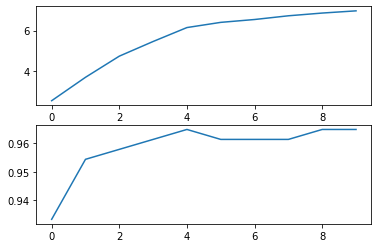

In [12]:
MLP = model(layers_size, activation)
#Training the model using Cross Entropy loss

epocs = 10
learning_rate = 0.1
overall_loss = []
overall_accuracy = []
for epoc in range(epocs):
  loss = []
  for count, (datum, y) in enumerate(zip(x_train, y_train)):
    # ypred = np.squeeze(MLP.forward_pass(datum.T))
    ypred = MLP.forward_pass(datum.T)

    # print('*********************')
    # loss.append(0.5 * np.sum((ypred - one_hot_y(y))**2))
    l = cross_entropy(ypred, y)
    loss.append(l)
    y = np.expand_dims(y, 1)
    # print(f'ypred{ypred.shape} y{y.shape}')
    # print(f'ypred_val{ypred} y_val{(y)}')
    dZ = (ypred - y)
    # print(f'dZ{dZ} {dZ.shape}')
    # if count%100==0:
    #   print('*********************')
    #   print(f'Actual Value:{y} Predicted Value: {ypred}')
    #   print(f'loss {round(loss[-1], 4)}, dZ{dZ}')
    MLP.backward_pass(dZ, learning_rate=learning_rate)

  
  agg_loss = np.mean(loss)
  overall_loss.append(agg_loss)
  # ypred  = MLP.predict(x_test.T)
  accuracy = get_accuracy()
  overall_accuracy.append(accuracy)
  if epoc%2==0:
    print(f'epoc: {epoc} Training loss: {round(agg_loss, 4)} Test Accuracy: {accuracy}') 
    learning_rate *= 0.75

plt.subplot(2,1,1)
plt.plot(overall_loss)
plt.subplot(2,1,2)
plt.plot(overall_accuracy)
plt.show

In [13]:
#Keras implentation for Cross checking the results
from keras.models import Sequential
from keras.layers import Dense

model = Sequential()
def add_layer(hidden_nodes, n_in, activation):
  model.add(Dense(hidden_nodes, input_dim=n_in, activation=activation))

for layer in range(len(layers_size)-2):
  add_layer(layers_size[layer+1], layers_size[layer], activation=activation[layer])

model.add(Dense(layers_size[-1], activation=activation[-1]))
model.compile(loss='categorical_crossentropy', optimizer='adam', metrics=['accuracy'])

model.summary()


Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense (Dense)                (None, 8)                 248       
_________________________________________________________________
dense_1 (Dense)              (None, 8)                 72        
_________________________________________________________________
dense_2 (Dense)              (None, 2)                 18        
Total params: 338
Trainable params: 338
Non-trainable params: 0
_________________________________________________________________


In [14]:
# #Dependencies
# import keras
# from keras.models import Sequential
# from keras.layers import Dense
# # Neural network
# model = Sequential()
# model.add(Dense(8, input_dim=4, activation='relu'))
# model.add(Dense(8, activation='relu'))
# model.add(Dense(3, activation='softmax'))

# model.compile(loss='categorical_crossentropy', optimizer='adam', metrics=['accuracy'])

In [15]:
history = model.fit(x_train, y_train, epochs=20, batch_size=1)

Epoch 1/20
284/284 [==============================] - 1s 1ms/step - loss: 0.3911 - accuracy: 0.8821
Epoch 2/20
284/284 [==============================] - 0s 1ms/step - loss: 0.1475 - accuracy: 0.9608
Epoch 3/20
284/284 [==============================] - 0s 1ms/step - loss: 0.0727 - accuracy: 0.9715
Epoch 4/20
284/284 [==============================] - 0s 1ms/step - loss: 0.0697 - accuracy: 0.9821
Epoch 5/20
284/284 [==============================] - 0s 993us/step - loss: 0.0424 - accuracy: 0.9886
Epoch 6/20
284/284 [==============================] - 0s 1ms/step - loss: 0.0268 - accuracy: 0.9965
Epoch 7/20
284/284 [==============================] - 0s 1ms/step - loss: 0.0392 - accuracy: 0.9914
Epoch 8/20
284/284 [==============================] - 0s 1ms/step - loss: 0.0346 - accuracy: 0.9933
Epoch 9/20
284/284 [==============================] - 0s 1ms/step - loss: 0.0298 - accuracy: 0.9924
Epoch 10/20
284/284 [==============================] - 0s 987us/step - loss: 0.0140 - accuracy: 0.